In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pyro
import pyro.distributions as dist
import scipy as sp
import scipy.stats
import time
import torch
import yaml
try:
    from yaml import CLoader as Loader
except ImportError:
    from yaml import Loader

In [2]:
# These scenes include uniformly randomly distributed nonpenetrating
# object arrangements
DATA_FILE = "data/20181127_uniform_feasible_1_box_1000/20181207_uniform_feasible_1_box_1000.yaml"
# These loaded scenes include squares on the left half of the scene, and
# long rectangles on the right half of the scene. All objects
# tend to lie along cardinal directions (theta = 0, pi/2, pi, ...)
#DATA_FILE = "data/20180709_sorted_grid_10000.yaml"

with open(DATA_FILE, "r") as f:
    environments = yaml.load(f, Loader=Loader)
    N_ENVIRONMENTS = len(environments.keys())
    print("Loaded %d environments from file %s" % (N_ENVIRONMENTS, DATA_FILE))
environments = [environments[key] for key in environments.keys()]

Loaded 1000 environments from file data/20181127_uniform_feasible_1_box_1000/20181207_uniform_feasible_1_box_1000.yaml


In [3]:
# Utilities
import generate_planar_scene_arrangements as psa_utils

def draw_rbt(ax, rbt, q):
    psa_utils.draw_board_state(ax, rbt, q)
    
    patch = patches.Rectangle([0., 0.], 1., 1., fill=True, color=[0., 1., 0.], 
                              linestyle='solid', linewidth=2, alpha=0.3)
    ax.add_patch(patch)
    
def draw_environment(environment, ax):
    rbt, q = psa_utils.build_rbt_from_summary(environment)
    draw_rbt(ax, rbt, q)

. Loss:  100.009001765
. . . . tensor([[2.2619e-02, 9.8821e-01, 8.1354e-01, 4.0236e-03, 1.9528e-03, 2.6952e-01,
         1.8234e-01, 4.5461e-01, 1.2102e+00, 7.1714e-03, 5.5762e-03, 1.7465e+00,
         8.9947e-01, 9.2309e-01, 8.4081e-01, 8.9207e-03, 5.5502e-03, 3.9019e-01,
         2.5380e-01, 3.1602e-01, 1.6142e+00, 1.2884e-02, 4.1712e-03, 4.7439e+00,
         3.9910e-01, 6.1211e-01, 8.9847e-01, 2.1307e-03, 2.0995e-03, 2.7060e+00,
         4.5627e-01, 6.7620e-01, 1.7713e+00, 8.8240e-03, 9.3397e-03, 5.7294e+00,
         8.2696e-01, 7.2417e-01, 8.3171e-01, 1.0054e-02, 1.3121e-02, 3.5241e+00,
         6.6848e-01, 4.7839e-01, 9.1665e-01, 5.9454e-03, 1.2075e-02, 5.4988e+00,
         4.9029e-01, 3.3108e-02, 8.3279e-01, 9.0304e-03, 2.8152e-03, 4.9978e-01,
         4.6925e-01, 4.6655e-01, 1.3875e+00, 1.9519e-03, 7.8394e-03, 2.0007e+00]],
       dtype=torch.float64, grad_fn=<TBackward>)


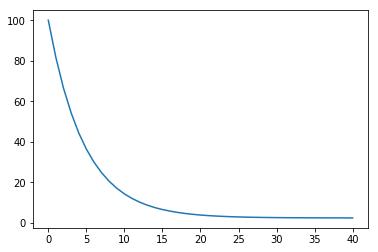

In [9]:
# Try out gradient descent through the projection operator
import differentiable_nlp as diff_nlp
from copy import deepcopy

device = torch.device('cpu')
env_i = environments[13]

rbt, qf = psa_utils.build_rbt_from_summary(env_i)
nq = rbt.get_num_positions()
#q = torch.tensor(qf.reshape(nq, 1), requires_grad=True)
np.random.seed(1)
q_start = np.random.random([nq, 1])
q = torch.tensor(q_start, requires_grad=True, dtype=torch.double)
q_target = torch.tensor(qf).view(nq, 1)

learning_rate = 0.05
constraints = [diff_nlp.object_origins_within_bounds_constraint_constructor_factory(
    np.array([0., 0., 0.5]), np.array([1., 1., 0.5]))]
losses = []
q_snapshots = []
q_pred_snapshots = []
for t in range(41):
    # Scheduling on the regularization in the derivative, which helps break off of
    # constraint surfaces during the first few iterations.
    q_pred = diff_nlp.projectToFeasibilityWithIKTorch.apply(q, rbt, constraints, 1/np.log(t+2))
    # Compute and print loss. Loss is a Tensor of shape (), and loss.item()
    # is a Python number giving its value.
    loss = (q_pred - q_target).pow(2).sum()
    losses.append(loss.cpu().detach().item())
    q_snapshots.append(q.cpu().detach().numpy().copy())
    q_pred_snapshots.append(q_pred.cpu().detach().numpy().copy())
    loss.backward()
    with torch.no_grad():
        q -= learning_rate * q.grad
        # Manually zero the gradients after running the backward pass
        q.grad.zero_()
    if t % 10 == 0:
        print ".",
    if t % 100 == 0:
        print "Loss: ", loss.cpu().detach().item()

print torch.t(q)
plt.figure()
plt.plot(losses)

In [10]:
from underactuated import PlanarRigidBodyVisualizer
from matplotlib import animation, rc
from IPython.display import HTML

Tview = np.array([[1., 0., 0., 0.],
                  [0., 1., 0., 0.],
                  [0., 0., 0., 0.],
                  [0., 0., 0., 1.]])

fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('equal')
ax.axis('off')
viz = PlanarRigidBodyVisualizer(
    rbt, Tview, xlim=[-0.25, 1.25], ylim=[-0.25, 1.25], ax=ax)
def animate_update(i):
    viz.draw(q_snapshots[i])
ani = animation.FuncAnimation(fig,
                              animate_update,
                              len(q_snapshots),
                              interval=2000/len(q_snapshots),
                              repeat=True)
plt.close(fig)
HTML(ani.to_html5_video()) # This needs to be the last line for the video to display

In [11]:
from underactuated import PlanarRigidBodyVisualizer
from matplotlib import animation, rc
from IPython.display import HTML

Tview = np.array([[1., 0., 0., 0.],
                  [0., 1., 0., 0.],
                  [0., 0., 0., 0.],
                  [0., 0., 0., 1.]])

fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('equal')
ax.axis('off')
viz = PlanarRigidBodyVisualizer(
    rbt, Tview, xlim=[-0.25, 1.25], ylim=[-0.25, 1.25], ax=ax)
def animate_update(i):
    viz.draw(q_pred_snapshots[i])
ani = animation.FuncAnimation(fig,
                              animate_update,
                              len(q_pred_snapshots),
                              interval=2000/len(q_pred_snapshots),
                              repeat=True)
plt.close(fig)
HTML(ani.to_html5_video()) # This needs to be the last line for the video to display

In [ ]:
# Ok, now deploy it in an inference context
from collections import namedtuple
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro import poutine
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate

pyro.enable_validation(True)

# Sample 
def model(data):
    i = 0
    keep_going = True
    
    object_world_prior_params = []
    for i in range(n_object_classes):
        object_world_prior_params.append(
            ObjectWorldPriorDescription(i)
        )
        
    sample_rates = pyro.sample('num_objects_weights', dist.Dirichlet(torch.ones(MAX_NUM_OBJECTS+1)))
    sample_distribution = dist.Categorical(sample_rates)
    
    # Generate in vectorized form for easier batch conversion at the end
    n = 1
    if data:
        if not isinstance(data, VectorizedEnvironments):
            raise ValueError("Expected VectorizedEnvironments input")
        if (data.idents.shape[1] != MAX_NUM_OBJECTS and
           data.poses.shape[1] != MAX_NUM_OBJECTS*3):
            raise ValueError("Got unexpected data shape.")
        n = data.idents.shape[0]
    with pyro.plate('data', n):
        generated_data = VectorizedEnvironments(
            idents=torch.LongTensor(n, MAX_NUM_OBJECTS),
            poses=torch.Tensor(n, MAX_NUM_OBJECTS*3),
            present=torch.Tensor(n, MAX_NUM_OBJECTS),
            n_samples=torch.Tensor(n))
        generated_data.idents[:, :] = -1
        generated_data.poses[:, :] = 0
        generated_data.present[:, :] = 0
        generated_data.n_samples[:] = 0

        # Sample actual number of samples immediately
        gt_n_samples = None
        if data is not None:
            gt_n_samples = data.n_samples
        num_samples = pyro.sample("num_samples", sample_distribution,
                                  obs=gt_n_samples)
        generated_data.n_samples[:] = num_samples
        
        for i in range(MAX_NUM_OBJECTS):
            gt_class = None
            gt_location = None
            gt_keep_going = None
            if data is not None:
                gt_class = data.idents[:, i]
                gt_location = data.poses[:, (i*3):(i*3+3)]
                gt_keep_going = data.present[:, i]
                
            keep_going = (i < num_samples)
            ci = sample_object_class(generated_data, i, keep_going, gt_class)
            location = sample_object_placement(ci, generated_data, i, keep_going, object_world_prior_params, gt_location)
            
            # Fill in generated data appropriately
            generated_data.idents[:, i] = ci.view(-1).type(torch.long)*keep_going.type(torch.long)
            for k in range(3):
                generated_data.poses[:, 3*i+k] = torch.Tensor(location[:, k])*keep_going.type(torch.float)
            generated_data.present[:, i] = keep_going
            # skip feasibility project for first pass
    return generated_data

for k in range(100):
     model()
print model()